## Importing Essential Libraries

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import *
from collections import Counter

import prince
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# pd.set_option('display.max_rows', 1000)

default_figsize = (15,5)

In [2]:
# Defining onehot encoder
def unique_keyword_search(df_col: pd.Series, num_selected: int) -> list:
    '''
    Performs unique keyword search on a dataframe's column for its most common keywords

    :param pd.Series df_col: column of a pd.DataFrame (e.g. df['col'])
    :param int num_selected: number of keywords
    :return: list of keywords in decreasing occurrence
    :rtype: list
    '''
    keywords = []
    for entry in df_col:
        words = entry.split(',')
        [keywords.append(word) for word in words]
    sorted_keywords = Counter(keywords).most_common()
    output_keywords = []
    for i in range(num_selected):
        output_keywords.append(sorted_keywords[i][0])
    return output_keywords

In [3]:
def onehot_encoder(df: pd.DataFrame, col_name: str, num_selected: int) -> pd.DataFrame:
    '''
    Performs one-hot encoding on a dataframe's column for its values with most occurrences

    :param pd.DataFrame df: dataframe to be processed
    :param str col_name: name of the encoded column
    :param int num_selected: number of values with most occurrences
    :return: processed dataframe
    :rtype: pd.DataFrame
    '''
    series = df[col_name].value_counts()
    selected_col_name = series.head(num_selected).index.tolist()

    for item in selected_col_name:
        df[col_name + "_" + item] = np.where(df[col_name] == item, 1, 0) # whenever df[col_name] == cat replace it with 1 else 0
        
    df.drop(columns=col_name, inplace=True)
    return df

In [4]:
def onehot_encoder_v2(df: pd.DataFrame, col_name: str, list_selected: list) -> pd.DataFrame:
    '''
    Performs one-hot encoding on a dataframe's column for its values with most occurrences

    :param pd.DataFrame df: dataframe to be processed
    :param str col_name: name of the encoded column
    :param list list_selected: list of most common values
    :return: processed dataframe
    :rtype: pd.DataFrame
    '''
    for item in list_selected:
        df[col_name + "_" + item] = np.where(df[col_name] == item, 1, 0) # whenever df[col_name] == cat replace it with 1 else 0
    df.drop(col_name, axis=1, inplace=True)

    return df

## Preparation of Dataframes

## organizations.csv
Put `organizations.csv` in this directory.

In [5]:
# org_df is the base of the unified csv
org_df = pd.read_csv("organizations.csv")

keep_col = ['uuid','name','rank','country_code','city','status','category_groups_list','num_funding_rounds','total_funding_usd','founded_on','employee_count','primary_role']
org_df = org_df[keep_col]

In [6]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230973 entries, 0 to 1230972
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   uuid                  1230973 non-null  object 
 1   name                  1230959 non-null  object 
 2   rank                  1230798 non-null  float64
 3   country_code          1040790 non-null  object 
 4   city                  1040790 non-null  object 
 5   status                1230973 non-null  object 
 6   category_groups_list  1151905 non-null  object 
 7   num_funding_rounds    193174 non-null   float64
 8   total_funding_usd     141546 non-null   float64
 9   founded_on            967522 non-null   object 
 10  employee_count        1230973 non-null  object 
 11  primary_role          1230973 non-null  object 
dtypes: float64(3), object(9)
memory usage: 112.7+ MB


Drop by category, founding date, primary role and industry

In [7]:
# filter by category group: keep fintech companies
# https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-
org_df.dropna(subset=['category_groups_list'], inplace=True)
# fintech_primary_keywords = ['Finance', 'Financial Services', 'FinTech', 'Personal Finance', 'Financial Exchanges', 'Bitcoin', 'Blockchain', 'Cryptocurrency', 'Payments']
fintech_category_groups = ['Commerce and Shopping','Financial Services','Lending and Investments','Payments']

# categories can be formed from one or more above elementary keywords
# org_df = org_df[org_df['category_list'].str.contains('|'.join(fintech_primary_keywords))]
org_df = org_df[org_df['category_groups_list'].str.contains('|'.join(fintech_category_groups))]
for keyword in fintech_category_groups:
    org_df[keyword] = org_df['category_groups_list'].str.contains(keyword)*1
# original col not dropped coz frontend needs it

In [8]:
# filter by founding date: on or after 2010-1-1, by 2020-12-31
# funding round announced date has the same restriction
org_df['founded_on'] = pd.to_datetime(org_df['founded_on'], errors='coerce', format='%Y-%m-%d')

start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2020, 12, 31)
after_start_date = org_df["founded_on"] >= start_date
before_end_date = org_df["founded_on"] <= end_date

org_df = org_df.loc[after_start_date & before_end_date]

In [9]:
# filter by primary role: only consider 'company'
# 'investor' and 'school' are dropped
org_df['primary_role'] = org_df['primary_role'].astype('string')
is_company = org_df['primary_role'] == 'company'
org_df = org_df[is_company]
org_df.drop(columns='primary_role', inplace=True)

In [10]:
org_df.reset_index(drop=True, inplace=True)
org_df.head()

,uuid,name,rank,country_code,city,status,category_groups_list,num_funding_rounds,total_funding_usd,founded_on,employee_count,Commerce and Shopping,Financial Services,Lending and Investments,Payments
0,46ad23bf-e380-3c7f-2adf-db3e7b74325f,Conecta 2,242152.0,USA,Palo Alto,closed,"Financial Services,Lending and Investments,Pro...",1.0,NaN,2012-06-06,1-10,0,1,1,0
1,fdd4bfe1-5f7b-e403-d100-91e9ec01f903,"VoiceSell, Inc.",39419.0,USA,Santa Clara,operating,"Artificial Intelligence,Commerce and Shopping,...",1.0,4.000000e+06,2018-12-01,11-50,1,0,0,0
2,74a20af3-f4dd-6188-de60-c4ee6cd0ca4a,Ant Group,2.0,CHN,Hangzhou,operating,"Commerce and Shopping,Financial Services,Inter...",4.0,2.200000e+10,2014-10-01,5001-10000,1,1,1,1
3,8fa7fd0d-d5cc-425d-52cc-a2019e7d42a3,Spout,179658.0,USA,Santa Monica,operating,"Financial Services,Information Technology,Priv...",1.0,NaN,2013-08-20,1-10,0,1,0,0
4,e256a713-8ddc-671e-6daf-619890e58b27,Feedmap,314066.0,NaN,NaN,operating,"Commerce and Shopping,Community and Lifestyle,...",NaN,NaN,2012-01-01,1-10,1,0,0,0


## funding_rounds.csv
Put `funding_rounds.csv` in this directory.

In [11]:
fd_rd_df = pd.read_csv("funding_rounds.csv")

# keep org_uuid for joining
keep_col = ['investment_type','announced_on','raised_amount_usd','investor_count','org_uuid','lead_investor_uuids'] 
fd_rd_df = fd_rd_df[keep_col]

In [12]:
# make a separate df for getting 1st funding (pre_seed/seed/angel)
first_funding_df = fd_rd_df[['investment_type','raised_amount_usd','org_uuid']]

is_pre_seed = first_funding_df['investment_type'] == 'pre_seed'
is_seed = first_funding_df['investment_type'] == 'seed'
is_angel = first_funding_df['investment_type'] == 'angel'

first_funding_df = first_funding_df.loc[is_pre_seed | is_seed | is_angel]
first_funding_df.head()

,investment_type,raised_amount_usd,org_uuid
0,angel,500000.0,df662812-7f97-0b43-9d3e-12f64f504fbb
6,seed,1500000.0,3d16cb4c-911e-75c0-de5a-15c316b39f98
8,seed,40000.0,21e77067-5537-408e-cad7-e5e72bb6ad86
28,seed,1000000.0,dca84eab-ed98-af47-7183-7420856db9ef
35,seed,700000.0,697df046-5264-0394-1ff2-7109a0d6e848


In [13]:
first_funding_df.drop(columns='investment_type', inplace=True)
first_funding_df.reset_index(drop=True, inplace=True)
first_funding_df = first_funding_df.groupby('org_uuid')['raised_amount_usd'].sum()
first_funding_df = first_funding_df.to_frame()
first_funding_df.rename(columns={'raised_amount_usd': 'first_fund_raised'}, inplace=True)
first_funding_df.head()
# first_funding_df will be joined back at last

,first_fund_raised
org_uuid,
000014da-0c46-b9cb-0941-3a93c027b119,0.0
00002470-bff7-6226-5800-0ca1b3787b6f,3400000.0
0000d497-c93a-eea3-eeb0-a943dfb4f71e,0.0
0001a8cc-0cdc-4a30-b4d3-da1b425069e1,0.0
0002aa63-f21b-4c54-9495-895a1d09e0d4,1500000.0


In [14]:
# drop null funding amounts
fd_rd_df.dropna(how='any',subset=['announced_on','raised_amount_usd'],inplace=True)

In [15]:
fd_rd_df['announced_on'] = pd.to_datetime(fd_rd_df['announced_on'], errors='coerce', format='%Y-%m-%d')

In [16]:
# filter by funding round announcement date:  on or after 2010-1-1, by 2020-12-31
# in accordance with org_df founding date restriction above
after_start_date = fd_rd_df["announced_on"] >= start_date
before_end_date = fd_rd_df["announced_on"] <= end_date

fd_rd_df = fd_rd_df.loc[after_start_date & before_end_date]

In [17]:
# count num of times of invested by top 100 investors
df_org_investor = fd_rd_df[['org_uuid','lead_investor_uuids']].dropna()
# convert to list of uuids
df_org_investor['lead_investor_uuids'] = df_org_investor['lead_investor_uuids'].str.split(',')
# get the list of top 100 investors
top_100_investors = pd.read_csv('top_100_investors.csv')['uuid'].to_numpy()

num_invested_by_top_100 = np.empty(0, dtype=int)

for arr in df_org_investor['lead_investor_uuids']:
    count = 0
    for uuid in arr:
        count += (uuid in top_100_investors)
    num_invested_by_top_100 = np.append(num_invested_by_top_100, count)

# df_org_investor will be joined at last using 'org_uuid' as index
df_org_investor['num_invested_by_top_100'] = num_invested_by_top_100
df_org_investor.drop(columns='lead_investor_uuids', inplace=True)
df_org_investor = df_org_investor.groupby(['org_uuid']).sum()
# df_org_investor['num_invested_by_top_100'].value_counts()

In [18]:
fd_rd_df.drop(columns='lead_investor_uuids', inplace=True)
fd_rd_df.set_index('announced_on', inplace=True)

In [19]:
ordinal_investment_type = []

# perform ordinal encoding: seed/angel=1, a=2, b=3, c=4, d=5, e=6, f or above=7 
for investment in fd_rd_df['investment_type']:
    if investment == 'seed' or investment == 'angel':
        ordinal_investment_type.append(1)
    elif investment == 'series_a':
        ordinal_investment_type.append(2)
    elif investment == 'series_b':
        ordinal_investment_type.append(3)
    elif investment == 'series_c':
        ordinal_investment_type.append(4)
    elif investment == 'series_d':
        ordinal_investment_type.append(5)
    elif investment == 'series_e':
        ordinal_investment_type.append(6)
    elif investment == 'series_f' or investment == 'series_g' or investment == 'series_h' \
    or investment == 'series_i' or investment == 'series_j':
        ordinal_investment_type.append(7)
    else:
        ordinal_investment_type.append(0)
        
fd_rd_df['latest_investment_type'] = ordinal_investment_type

In [20]:
irregular_funding = fd_rd_df['investment_type'].value_counts().drop(['seed','angel','series_a','series_b','series_c','series_d','series_e','series_f','series_g','series_h','series_i','series_j']).index.tolist()
print(irregular_funding)

['series_unknown', 'grant', 'debt_financing', 'pre_seed', 'post_ipo_equity', 'convertible_note', 'equity_crowdfunding', 'private_equity', 'undisclosed', 'post_ipo_debt', 'corporate_round', 'product_crowdfunding', 'non_equity_assistance', 'initial_coin_offering', 'secondary_market', 'post_ipo_secondary']


In [21]:
onehot_encoder_v2(fd_rd_df, 'investment_type', irregular_funding)

,raised_amount_usd,investor_count,org_uuid,latest_investment_type,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary
announced_on,,,,,,,,,,,,,,,,,,,,
2016-11-06,15000000.0,3.0,8a899f9c-886e-2b9c-378e-49bbeb316cfc,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-03-31,1500000.0,1.0,31f9d866-3660-5367-8c52-028a7610e441,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-11-26,5000000.0,4.0,95b566c0-b31a-4586-23f8-5eee072ea621,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-12-01,1000000.0,1.0,e212a930-25b3-2de3-3c6c-19f0965fcb47,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-09,1000000.0,2.0,e62b140b-2321-d4b5-a74c-19d989be276b,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,65000.0,NaN,7091dcc8-0886-4fc8-af3b-864a2adf986c,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-02-17,291337.0,NaN,33eceaba-87d5-4526-ac4a-18a18caf9f67,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2014-10-01,142800.0,3.0,8004c9c8-2a7a-4e40-a1df-adea3985bf8a,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
irregular_funding = ['investment_type_' + investment for investment in irregular_funding]

groupby_dict = {
    'raised_amount_usd': np.sum,
    'investor_count': np.sum,
    'latest_investment_type': np.max
}
for key in irregular_funding:
    groupby_dict[key] = np.sum

# resample by quarter to avoid data corruption by wrong values
fd_rd_df = fd_rd_df.groupby([pd.Grouper(freq='Q', closed='left'), 'org_uuid']).agg(groupby_dict)
fd_rd_df.reset_index(inplace=True)
fd_rd_df.sort_values(by=['org_uuid','announced_on'])
fd_rd_df.reset_index(drop=True, inplace=True)

In [23]:
# convert datetime into number of years
num_data = len(fd_rd_df)
today = ["2021-01-28"] * num_data
fd_rd_df['today'] = pd.DataFrame(today)
fd_rd_df['time'] = (pd.to_datetime(fd_rd_df['today'], errors='coerce', format='%Y-%m-%d') - \
              pd.to_datetime(fd_rd_df['announced_on'], errors='coerce', format='%Y-%m-%d'))

fd_rd_df['time'] = pd.to_numeric(fd_rd_df['time'].dt.days, downcast='integer')
fd_rd_df['time_in_year'] = fd_rd_df['time'].apply(lambda x: round(int(x)/365,4))
fd_rd_df.drop(columns=['today','time'], inplace=True)
fd_rd_df.head()

,announced_on,org_uuid,raised_amount_usd,investor_count,latest_investment_type,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary,time_in_year
0,2010-03-31,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,260000000.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8384
1,2010-03-31,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,500000.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8384
2,2010-03-31,006d0b80-23fd-e6d6-b916-1fb3e39ecdee,2195236.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8384
3,2010-03-31,009e8957-d102-c674-6c9c-98eb11ac8e32,6500000.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8384
4,2010-03-31,00a4c0e1-c056-4aa7-9262-696dc5192466,8000000.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.8384


In [24]:
# sort from closest to furthest in time, then group data
fd_rd_df = fd_rd_df.sort_values(by='time_in_year', ascending=False)
fd_rd_df = fd_rd_df.merge(fd_rd_df.groupby('org_uuid').agg(raised_amount_usd_list=('raised_amount_usd',list), latest_investment_list=('latest_investment_type',list), time_in_year_list = ('time_in_year',list)).reset_index())
fd_rd_df.drop(columns=['raised_amount_usd','latest_investment_type','time_in_year'], inplace=True)
fd_rd_df.head()

,announced_on,org_uuid,investor_count,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary,raised_amount_usd_list,latest_investment_list,time_in_year_list
0,2010-03-31,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[0, 2, 0, 0, 0]","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]"
1,2017-12-31,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[0, 2, 0, 0, 0]","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]"
2,2018-12-31,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[0, 2, 0, 0, 0]","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]"
3,2019-09-30,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[0, 2, 0, 0, 0]","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]"
4,2020-12-31,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,10.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[0, 2, 0, 0, 0]","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]"


In [25]:
irregular_funding_df = fd_rd_df[['org_uuid'] + irregular_funding]
irregular_funding_df_max = irregular_funding_df.groupby('org_uuid').sum()

In [26]:
fd_rd_df.drop_duplicates(subset='org_uuid', inplace=True)
fd_rd_df = fd_rd_df[['org_uuid','latest_investment_list','raised_amount_usd_list','time_in_year_list']]
fd_rd_df = fd_rd_df.set_index('org_uuid').join(irregular_funding_df_max)
fd_rd_df['latest_investment_list'] = fd_rd_df['latest_investment_list'].apply(max)
fd_rd_df.rename(columns={'latest_investment_list': 'latest_investment'}, inplace=True)
fd_rd_df.head()

,latest_investment,raised_amount_usd_list,time_in_year_list,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary
org_uuid,,,,,,,,,,,,,,,,,,,
003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,2,"[260000000.0, 3689600.0, 10086407.0, 48063500....","[10.8384, 3.0795, 2.0795, 1.3315, 0.0767]",2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
9ee87a58-15e9-2640-7578-4096611abd9e,3,"[4000000.0, 100000.0, 4635000.0, 850000.0, 331...","[10.8384, 9.8384, 8.5863, 7.3342, 5.8356]",1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0
a96f7ec5-5914-9f06-f38a-39eacdd8c3fb,0,[980000.0],[10.8384],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
a9c4bceb-711d-4155-bc5e-1698f7cbc972,3,"[2928804.0, 20331200.0]","[10.8384, 6.0822]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
a9d8ce09-b7aa-5415-7f98-f7b41b046af6,0,"[3100000.0, 13369999.0]","[10.8384, 3.0795]",0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0


In [27]:
amount_list = []

for amount in fd_rd_df['raised_amount_usd_list']:
    # find change in amount normalized to the smaller amount
    norm_amount_delta = [2 * (j - i)/ (i + j) if (i + j) != 0 else 0 for i, j in zip(amount[: -1], amount[1 :])]
    amount_list.append(norm_amount_delta if len(norm_amount_delta) else None)

fd_rd_df['norm_amount_delta'] = amount_list

In [28]:
time_elapsed_successive = []

for time in fd_rd_df['time_in_year_list']:
    time_elapsed = [(i-j) if len(time) != 1 else 0 for i, j in zip(time[: -1], time[1 :])]
    time_elapsed_successive.append(time_elapsed)
    
fd_rd_df['time_elapsed_successive_two_funds'] = time_elapsed_successive
fd_rd_df.reset_index(inplace=True)

In [29]:
# include calculation of momentum based on latest two funds, and its change
momentum = []
for y in range(len(fd_rd_df['norm_amount_delta'])):
    if fd_rd_df['norm_amount_delta'].iloc[y] != None:
        change = []
        for j, k in zip(fd_rd_df['norm_amount_delta'].iloc[y][:], fd_rd_df['time_elapsed_successive_two_funds'].iloc[y][:]):
            if k != 0:
                change.append((j)/k)
            else:
                change.append("inf")
    else:
        change = None
    momentum.append(change)

fd_rd_df['momentum'] = momentum

In [30]:
fd_rd_df.drop(columns=['raised_amount_usd_list','time_in_year_list','time_elapsed_successive_two_funds'], inplace=True)
fd_rd_df

,org_uuid,latest_investment,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary,norm_amount_delta,momentum
0,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,2,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,"[-1.9440311639139352, 0.9286881169558059, 1.30...","[-0.2505549967023592, 0.9286881169558059, 1.74..."
1,9ee87a58-15e9-2640-7578-4096611abd9e,3,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,"[-1.9024390243902438, 1.9155227032734952, -1.3...","[-1.9024390243902438, 1.5298480179486418, -1.1..."
2,a96f7ec5-5914-9f06-f38a-39eacdd8c3fb,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,None,None
3,a9c4bceb-711d-4155-bc5e-1698f7cbc972,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[1.496336458067677],[0.3146075560463557]
4,a9d8ce09-b7aa-5415-7f98-f7b41b046af6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,[1.2471159227149922],[0.1607335991848061]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127676,54a1740d-d88e-45c4-8466-e97829118e82,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None
127677,5499bd62-6c02-4261-9923-c5a7d6c55845,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None
127678,54459a4b-2844-4a87-b88e-4bf820031609,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None
127679,5428b5b6-72f5-44c5-882a-473781c44ba4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None


In [31]:
# find mean delta
mean_amount_delta_list = []

for delta_list in fd_rd_df['norm_amount_delta']:
    mean_amount_delta_list.append(np.array(delta_list).mean() if delta_list != None else None)

fd_rd_df['mean_norm_amount_delta'] = mean_amount_delta_list

In [32]:
# find mean funding momentum
mean_momentum_list = []

for momentum_list in fd_rd_df['momentum']:
    mean_momentum_list.append(np.array(momentum_list).mean() if momentum_list is not None else None)

fd_rd_df['mean_momentum'] = mean_momentum_list

In [33]:
fd_rd_df.dropna(inplace=True)
fd_rd_df = fd_rd_df.set_index('org_uuid').join(df_org_investor)
fd_rd_df = fd_rd_df.join(first_funding_df)
fd_rd_df.reset_index(inplace=True)
fd_rd_df.head()

,org_uuid,latest_investment,investment_type_series_unknown,investment_type_grant,investment_type_debt_financing,investment_type_pre_seed,investment_type_post_ipo_equity,investment_type_convertible_note,investment_type_equity_crowdfunding,investment_type_private_equity,investment_type_undisclosed,investment_type_post_ipo_debt,investment_type_corporate_round,investment_type_product_crowdfunding,investment_type_non_equity_assistance,investment_type_initial_coin_offering,investment_type_secondary_market,investment_type_post_ipo_secondary,norm_amount_delta,momentum,mean_norm_amount_delta,mean_momentum,num_invested_by_top_100,first_fund_raised
0,003b7da7-7e0a-1ebe-c32c-19210e9dcbdd,2,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,"[-1.9440311639139352, 0.9286881169558059, 1.30...","[-0.2505549967023592, 0.9286881169558059, 1.74...",0.302786,0.789448,0.0,NaN
1,9ee87a58-15e9-2640-7578-4096611abd9e,3,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,"[-1.9024390243902438, 1.9155227032734952, -1.3...","[-1.9024390243902438, 1.5298480179486418, -1.1...",-0.045659,-0.171125,0.0,NaN
2,a9c4bceb-711d-4155-bc5e-1698f7cbc972,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[1.496336458067677],[0.3146075560463557],1.496336,0.314608,NaN,NaN
3,a9d8ce09-b7aa-5415-7f98-f7b41b046af6,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,[1.2471159227149922],[0.1607335991848061],1.247116,0.160734,NaN,NaN
4,aa0f8e75-0511-1030-d424-e976ede9820c,5,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,"[-1.0702150635320609, 0.23714894130703743, 0.0...","[-4.291159035814204, 0.3159458317439879, 0.066...",-0.193317,-0.501638,NaN,NaN


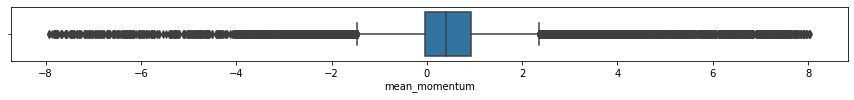

In [34]:
fig, ax = plt.subplots(figsize=(15,1))
sns.boxplot(data=fd_rd_df, x='mean_momentum')
plt.show()

## event_appearances.csv
Put `event_appearances.csv` in this directory.

In [35]:
event_df = pd.read_csv("event_appearances.csv")

keep_col = ['participant_uuid', 'participant_name']
event_df = event_df[keep_col]

In [36]:
# count the events attended by companies
event_count_dict = event_df['participant_name'].value_counts().to_dict()
event_df['event_count'] = event_df['participant_name'].map(event_count_dict)
event_df.drop_duplicates(inplace=True)
event_df.sort_values(by='event_count', ascending=False, inplace=True)
event_df.drop(columns='participant_name', inplace=True)
event_df.reset_index(drop=True, inplace=True)

## people.csv
Put `people.csv` in this directory.

In [37]:
# don't drop null here
# the uuid is useful for future joining of other CSV
ppl_df = pd.read_csv("people.csv")

keep_col = ['uuid','gender']
ppl_df = ppl_df[keep_col]

In [38]:
ppl_df = onehot_encoder(ppl_df, 'gender', 2) # male and female
ppl_df.reset_index(drop=True, inplace=True)

## degrees.csv
Put `degrees.csv` in this directory.

In [39]:
deg_df = pd.read_csv("degrees.csv")

keep_col = ['person_uuid','degree_type','subject','started_on','completed_on','is_completed']
deg_df = deg_df[keep_col]

In [40]:
deg_df.drop_duplicates(inplace=True)

degree_type_to_drop = (deg_df['degree_type'] == 'unknown') | (deg_df['degree_type'] == 'Unknown') | (deg_df['degree_type'] == 'Specialization') | (deg_df['degree_type'] == 'Certificate') | (deg_df['degree_type'] == 'Certification')
deg_df = deg_df.drop(deg_df[degree_type_to_drop].index)
deg_df = deg_df.drop(deg_df[deg_df['subject'] == 'unknown'].index)

In [41]:
# use keyword to search for relevant degrees
bachelor_keyword = ['Bachelor', 'Degree', 'BS', 'BSc', 'B.S.', 'Bsc', 'B.S',
'BENG', 'BEng', 'B.Eng.', 'Beng', 'B.Eng', 'BE', 'B.E', 'BA', 'Ba', 'B.A.', 'B.A', 'A.B.', 'AB',
'BBA', 'B.B.A.', 'B.B.A', 'B.Tech', 'B.Tech.', 'B.Com.', 'J.D.', 'JD', 'Juris Doctor']

master_keyword = ['Master', 'Postgraduate', 'Graduate', 'MPHIL', 'MPhil', 'Mphil', 'M.Phil.', 'M.phil', 'M.Phil', 'M.S',
'MS', 'MSc', 'M.Sc', 'Msc', 'MENG', 'MEng', 'M.Eng.', 'M.eng.',
'MA', 'M.A', 'MBA', 'M.B.A.', 'M.B.A', 'Mba', 'M.BA.', 'M.Ba.', 'LLM']

phd_keyword = ['PHD', 'Phd', 'PhD', 'P.HD', 'P.Hd', 'P.hd', 'P.H.D', 'Ph.D.', 'Ph.D.', 'PhD']

deg_df['degree_type'].fillna(value='N/A', inplace=True)
deg_df.loc[deg_df['degree_type'].str.contains('|'.join(phd_keyword)),'degree_type']='PhD'
deg_df.loc[deg_df['degree_type'].str.contains('|'.join(master_keyword)),'degree_type']='Master'
deg_df.loc[deg_df['degree_type'].str.contains('|'.join(bachelor_keyword)),'degree_type']='Bachelor'

degree_type = []

# perform ordinal encoding: bachelor = 1, master = 2, PhD = 3, no/others = 0
for degree in deg_df['degree_type']:
    if degree == 'Bachelor':
        degree_type.append(1)
    elif degree == 'Master':
        degree_type.append(2)
    elif degree == 'PhD':
        degree_type.append(3)
    else:
        degree_type.append(0)
        
deg_df['degree_type'] = degree_type

In [42]:
# use keyword to search for relevant subjects
# the grouping is manually done
# it is NOT an exact / unique classification
stem_keyword = ['Computer Science', 'Computer science', 'CS', 'EE', 'Engineering', 'Mathematics', 'Statistics', 'Physics', 'Chemistry', 'Biology', 'Biochemistry', 'Information Technology', 'Electronics', 'Electrical', 'Mechanical', 'Biological Sciences', 'Neuroscience', 'Biotechnology', 'Bioengineering', 'Artificial Intelligence', 'Telecommunications', 'Materials Science', 'Cognitive Science', 'Information Science', 'Medicine']
business_keyword = ['Business', 'Economics', 'Finance', 'Accounting', 'Marketing', 'Management', 'Information System', 'Entrepreneurship', 'MBA', 'Commerce', 'Accountancy', 'Operations Research', 'Human Resources']
arts_sosc_keyword = ['Arts', 'Humanities', 'Language', 'English', 'History', 'Geography', 'Social Science', 'Political Science', 'Psychology', 'Sociology', 'International Relations', 'Journalism', 'Communication', 'Politics', 'Anthropology', 'Government', 'Public Policy', 'Public Administration', 'Law', 'Philosophy']

deg_df['subject'].fillna(value='N/A', inplace=True)
deg_df.loc[deg_df['subject'].str.contains('|'.join(stem_keyword)),'subject']='STEM'
deg_df.loc[deg_df['subject'].str.contains('|'.join(business_keyword)),'subject']='Business'
deg_df.loc[deg_df['subject'].str.contains('|'.join(arts_sosc_keyword)),'subject']='Arts_SoSc'

In [43]:
# counts = deg_df['subject'].value_counts()
# counts

In [44]:
deg_df = onehot_encoder(deg_df, 'subject', 4)
deg_df.drop(columns='subject_N/A', inplace=True)

In [45]:
deg_df['subject_Business'] = deg_df.groupby('person_uuid')['subject_Business'].transform('sum')
deg_df['subject_STEM'] = deg_df.groupby('person_uuid')['subject_STEM'].transform('sum')
deg_df['subject_Arts_SoSc'] = deg_df.groupby('person_uuid')['subject_Arts_SoSc'].transform('sum')

In [46]:
deg_df.sort_values(by='degree_type', ascending=False, inplace=True) # PhD > Master > Bachelor
deg_df = deg_df.drop_duplicates(subset='person_uuid', keep="first") # only consider the highest degree obtained

degree_date = ['started_on', 'completed_on']
has_degree = np.where(deg_df['degree_type'] != 0, 1, 0)

# ignore for now
# for col in degree_date:
#     deg_df[col] = pd.to_datetime(deg_df[col], errors='coerce', format='%Y-%m-%d') # 'coerce' converts NaN to NaT
#     mean = deg_df[col].mean()
#     deg_df.loc[has_degree,col].fillna(value=mean, inplace=True)

deg_df['is_completed'].fillna(value=0, inplace=True)
deg_df['is_completed'] = deg_df['is_completed']*1

deg_df.reset_index(drop=True, inplace=True)

In [47]:
# join people and degrees
# ppl_deg_join_df = ppl_df + deg_df
ppl_deg_join_df = ppl_df.set_index('uuid').join(deg_df.set_index('person_uuid'))

# some cols will use 0 as the fillna() value
col_nan_to_zero = ['degree_type','is_completed','subject_Business','subject_STEM','subject_Arts_SoSc']
for col in col_nan_to_zero:
    ppl_deg_join_df[col].fillna(value=0, inplace=True)

ppl_deg_join_df.reset_index(inplace=True)

## jobs.csv
Put `jobs.csv` in this directory.

In [48]:
job_df = pd.read_csv("jobs.csv")

keep_col = ['person_uuid','org_uuid','started_on','ended_on','is_current']
job_df = job_df[keep_col]

In [49]:
job_is_current = job_df['is_current'].array
job_df.loc[job_is_current,'ended_on'] = job_df.loc[job_is_current,'ended_on'].fillna('2020-12-31')
job_df.drop(columns='is_current', inplace=True)

# find the duration of the job
job_df['job_duration'] = pd.to_datetime(job_df['ended_on'], errors='coerce', format='%Y-%m-%d') - pd.to_datetime(job_df['started_on'], errors='coerce', format='%Y-%m-%d')
# take mean for NaN
mean = job_df['job_duration'].mean()
job_df['job_duration'].fillna(value=mean, inplace=True)
# convert TimeDelta to int
job_df['job_duration'] = job_df['job_duration'].apply(lambda x: x.days)

job_df.drop(columns=['started_on','ended_on'], inplace=True)

# join jobs and ppl_deg_join_df
# ppl_deg_job_join_df = job_df + ppl_deg_join_df
ppl_deg_job_join_df = job_df.set_index('person_uuid').join(ppl_deg_join_df.set_index('uuid'))

ppl_deg_job_join_df.drop(columns=['started_on','completed_on','is_completed'], inplace=True)
ppl_deg_job_join_df.reset_index(drop=True, inplace=True)
ppl_deg_job_join_df.fillna(value=0, inplace=True)

In [50]:
ppl_deg_job_join_df.head()

,org_uuid,job_duration,gender_male,gender_female,degree_type,subject_Business,subject_STEM,subject_Arts_SoSc
0,75685ae6-5ba1-0ffb-80ba-3c0bf539e04d,2188,1,0,0.0,0.0,0.0,0.0
1,867f0af5-a1d0-143d-bbed-5cc252ca40d6,2188,0,1,3.0,0.0,0.0,1.0
2,655ff5a2-33d2-dfe5-af13-20866a58a5c0,1036,1,0,1.0,0.0,1.0,0.0
3,bf0eb7c9-a5c4-014f-fb7c-f6530084e4d5,2188,0,1,0.0,0.0,0.0,0.0
4,cab0141c-849d-56e9-8173-56fcd95c5dd1,2188,1,0,1.0,1.0,0.0,0.0


In [51]:
ppl_deg_job_join_df = ppl_deg_job_join_df.groupby(['org_uuid']).sum()

In [52]:
ppl_deg_job_join_df['gender_male'] = ppl_deg_job_join_df['gender_male'].astype(float)
ppl_deg_job_join_df['gender_female'] = ppl_deg_job_join_df['gender_female'].astype(float)

num_male = ppl_deg_job_join_df['gender_male'].to_numpy()
num_female = ppl_deg_job_join_df['gender_female'].to_numpy()
num_exec = np.add(num_male, num_female)

num_mean_deg = ppl_deg_job_join_df['degree_type'].to_numpy()
num_Busi = ppl_deg_job_join_df['subject_Business'].to_numpy()
num_STEM = ppl_deg_job_join_df['subject_STEM'].to_numpy()
num_Arts_SoSc = ppl_deg_job_join_df['subject_Arts_SoSc'].to_numpy()

In [53]:
ppl_deg_job_join_df['num_exec'] = num_exec

ppl_deg_job_join_df['gender_male'] = np.divide(num_male, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)
ppl_deg_job_join_df['gender_female'] = np.divide(num_female, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)
ppl_deg_job_join_df['degree_type'] = np.divide(num_mean_deg, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)
ppl_deg_job_join_df['subject_Business'] = np.divide(num_Busi, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)
ppl_deg_job_join_df['subject_STEM'] = np.divide(num_STEM, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)
ppl_deg_job_join_df['subject_Arts_SoSc'] = np.divide(num_Arts_SoSc, num_exec, out=np.zeros_like(num_exec), where=num_exec!=0)

In [54]:
ppl_deg_job_join_df.head()

,job_duration,gender_male,gender_female,degree_type,subject_Business,subject_STEM,subject_Arts_SoSc,num_exec
org_uuid,,,,,,,,
00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,6564,1.000000,0.000000,0.000000,0.0,0.000000,0.0,3.0
000014da-0c46-b9cb-0941-3a93c027b119,13134,0.666667,0.333333,0.333333,0.0,0.000000,0.0,6.0
0000221d-6dfd-a049-dcfc-b4a5ca3b0fe7,2188,1.000000,0.000000,1.000000,1.0,0.000000,0.0,1.0
00002470-bff7-6226-5800-0ca1b3787b6f,12114,1.000000,0.000000,0.833333,0.0,0.833333,0.0,6.0
00003a2c-ad4d-ff61-997b-7b22b2320895,2661,1.000000,0.000000,0.000000,0.0,0.000000,0.0,2.0


## acquisitions.csv
Put `acquisitions.csv` in this directory.

In [55]:
acq_df = pd.read_csv("acquisitions.csv")

keep_col = ['acquiree_uuid','acquired_on','price_usd']
acq_df = acq_df[keep_col]

acq_df.dropna(how='all', subset=['acquired_on','price_usd'], inplace=True)

In [56]:
fund_df = pd.read_csv("funds.csv") #investors' investment funds

org_parent_df= pd.read_csv("org_parents.csv") #Mapping between parent organizations and subsidiaries

In [57]:
#All dataframes are now ready, org_df is the master dataframe
org_df.head()

,uuid,name,rank,country_code,city,status,category_groups_list,num_funding_rounds,total_funding_usd,founded_on,employee_count,Commerce and Shopping,Financial Services,Lending and Investments,Payments
0,46ad23bf-e380-3c7f-2adf-db3e7b74325f,Conecta 2,242152.0,USA,Palo Alto,closed,"Financial Services,Lending and Investments,Pro...",1.0,NaN,2012-06-06,1-10,0,1,1,0
1,fdd4bfe1-5f7b-e403-d100-91e9ec01f903,"VoiceSell, Inc.",39419.0,USA,Santa Clara,operating,"Artificial Intelligence,Commerce and Shopping,...",1.0,4.000000e+06,2018-12-01,11-50,1,0,0,0
2,74a20af3-f4dd-6188-de60-c4ee6cd0ca4a,Ant Group,2.0,CHN,Hangzhou,operating,"Commerce and Shopping,Financial Services,Inter...",4.0,2.200000e+10,2014-10-01,5001-10000,1,1,1,1
3,8fa7fd0d-d5cc-425d-52cc-a2019e7d42a3,Spout,179658.0,USA,Santa Monica,operating,"Financial Services,Information Technology,Priv...",1.0,NaN,2013-08-20,1-10,0,1,0,0
4,e256a713-8ddc-671e-6daf-619890e58b27,Feedmap,314066.0,NaN,NaN,operating,"Commerce and Shopping,Community and Lifestyle,...",NaN,NaN,2012-01-01,1-10,1,0,0,0


## ipo.csv

In [58]:
# Some prefixes are needed due to duplicate coulmn names with other csv
# Some repeated columns existing info in other dataframes can be deleted
acq_df = acq_df.add_prefix('acq_')
fund_df = fund_df.add_prefix('funds_')
fd_rd_df = fd_rd_df.add_prefix('fd_rd_')

org_parent_df = org_parent_df.add_prefix('parent_org_')

## Handle investor, partners and fundings. As a partner is also an investor himself, two joinings are needed

In [59]:
ipo_df = pd.read_csv("ipos.csv")

keep_col = ['org_uuid','went_public_on','share_price_usd','valuation_price_usd','money_raised_usd']
ipo_df = ipo_df[keep_col]

In [60]:
ipo_df = ipo_df.add_prefix('ipo_')

## Now, it is time to handle organizations, put org_uuid as index

In [61]:
#Joining Organizations and fund_rounds
org_join = org_df.set_index('uuid').join(fd_rd_df.set_index('fd_rd_org_uuid'))

In [62]:
#Joining Organizations and IPO
org_join = org_join.join(ipo_df.set_index('ipo_org_uuid'))

In [63]:
#Joining Organizations and funds
org_join = org_join.join(fund_df.set_index('funds_entity_uuid'))

In [64]:
#Joining Organizations and acquisitions
org_join = org_join.join(acq_df.set_index('acq_acquiree_uuid'))

In [65]:
#Joining Organizations and its parents, if any
org_join = org_join.join(org_parent_df.set_index('parent_org_uuid'))

In [66]:
#Joining Organizations and Organization Event Participant
org_join = org_join.join(event_df.set_index('participant_uuid'))

## Have a look at the current large dataframes and drop some columns (org_join)

In [67]:
#Drop away emtpy columns to improve efficiency
org_join.dropna(how = 'all', axis = 1, inplace = True)

In [68]:
org_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103689 entries, 00002470-bff7-6226-5800-0ca1b3787b6f to ffffd950-2359-4282-bc8d-38f7e40707d2
Data columns (total 66 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   name                                         103687 non-null  object        
 1   rank                                         103686 non-null  float64       
 2   country_code                                 89575 non-null   object        
 3   city                                         89575 non-null   object        
 4   status                                       103689 non-null  object        
 5   category_groups_list                         103689 non-null  object        
 6   num_funding_rounds                           29760 non-null   float64       
 7   total_funding_usd                            22546 non-null   float64       
 8   foun

In [69]:
#Drop away columns that are without any use to improve efficiency
org_join = org_join.drop(columns=['parent_org_rank','funds_name','funds_type','funds_permalink','funds_cb_url',\
                                 'funds_created_at','funds_updated_at','funds_entity_name','funds_entity_type',\
                                 'funds_announced_on','funds_raised_amount','funds_raised_amount_currency_code',\
                                 'parent_org_name','parent_org_type','parent_org_permalink','parent_org_cb_url',\
                                 'parent_org_rank','parent_org_created_at','parent_org_updated_at','parent_org_parent_name'])

## Finally, it is about the linkage between people and organization, through "job"

In [70]:
# join organization with ppl
org_join = org_join.join(ppl_deg_job_join_df)

In [71]:
org_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103689 entries, 00002470-bff7-6226-5800-0ca1b3787b6f to ffffd950-2359-4282-bc8d-38f7e40707d2
Data columns (total 55 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   name                                         103687 non-null  object        
 1   rank                                         103686 non-null  float64       
 2   country_code                                 89575 non-null   object        
 3   city                                         89575 non-null   object        
 4   status                                       103689 non-null  object        
 5   category_groups_list                         103689 non-null  object        
 6   num_funding_rounds                           29760 non-null   float64       
 7   total_funding_usd                            22546 non-null   float64       
 8   foun

### Information about the first funding round

In [72]:
#Initialize dataframe for features
fund_rd_df= pd.read_csv("funding_rounds.csv")
export_df=fund_rd_df[["uuid","investment_type", "raised_amount_usd", "post_money_valuation_usd", "investor_count", "org_uuid"]]
export_df["investment_type"].value_counts()

seed                     103205
series_unknown            61298
series_a                  42280
series_b                  21187
grant                     20481
angel                     19056
pre_seed                  17694
debt_financing            14050
private_equity            11093
series_c                   9823
post_ipo_equity            7550
convertible_note           7417
equity_crowdfunding        6342
non_equity_assistance      5409
undisclosed                5251
series_d                   4136
corporate_round            3335
post_ipo_debt              1743
series_e                   1719
product_crowdfunding       1023
secondary_market            790
initial_coin_offering       680
series_f                    617
series_g                    214
post_ipo_secondary           94
series_h                     90
series_i                     19
series_j                     13
Name: investment_type, dtype: int64

In [73]:
#Dropping rows that are not seed, pre-seed or angel 
indexnames= export_df[(export_df["investment_type"]!= "seed") &(export_df["investment_type"]!= "angel")& (export_df["investment_type"]!= "pre_seed") ].index
export_df.drop(indexnames , inplace=True)
export_df= export_df.reset_index()
export_df

/opt/anaconda3/envs/UBS/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,index,uuid,investment_type,raised_amount_usd,post_money_valuation_usd,investor_count,org_uuid
0,0,8a945939-18e0-cc9d-27b9-bf33817b2818,angel,500000.0,NaN,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb
1,6,7066cfde-674a-0fc4-514c-bf3c9b0d7b2e,seed,1500000.0,NaN,4.0,3d16cb4c-911e-75c0-de5a-15c316b39f98
2,8,e5b9d3d3-cdf5-b481-c42f-bb818225402c,seed,40000.0,NaN,2.0,21e77067-5537-408e-cad7-e5e72bb6ad86
3,28,4b50fe59-eebe-3d11-0e17-c354d6045385,seed,1000000.0,NaN,2.0,dca84eab-ed98-af47-7183-7420856db9ef
4,35,106fa953-e1ff-5f52-c81c-bb026fabda6c,seed,700000.0,NaN,1.0,697df046-5264-0394-1ff2-7109a0d6e848
...,...,...,...,...,...,...,...
139950,366604,25ee3f19-a8de-43b1-b5e1-fbe2a8a262b4,pre_seed,65000.0,415000.0,NaN,7091dcc8-0886-4fc8-af3b-864a2adf986c
139951,366605,c7a9cb50-4164-4336-8332-6bd7b83ae4b4,angel,291337.0,NaN,NaN,33eceaba-87d5-4526-ac4a-18a18caf9f67
139952,366606,b9cb094a-91de-4559-8116-3e97fcd9442b,angel,142800.0,NaN,3.0,8004c9c8-2a7a-4e40-a1df-adea3985bf8a
139953,366607,8ac9dcac-b1e9-4d97-ad17-685c36b1f4ee,pre_seed,50000.0,NaN,1.0,9d92669d-1d86-4ef5-97c5-50a8903d3ffa


In [74]:
# Suming up investment by org_uuid and return "final_df"
final_df= export_df.groupby("org_uuid")["raised_amount_usd","post_money_valuation_usd", "investor_count" ].sum()
export_df= export_df.drop(columns=["raised_amount_usd", "post_money_valuation_usd", "investor_count", "investment_type"])

#Joining original df with final_df that sumed up the data 
final_df= final_df.join(export_df.set_index("org_uuid"))
final_df= final_df.reset_index()
final_df= final_df.drop_duplicates(subset=['org_uuid'])
export_df= export_df.drop(columns=["index"])
final_df= final_df.reset_index()


org_join = org_join.join(final_df.set_index('org_uuid'))

<ipython-input-74-9fe01d75f2b7>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_df= export_df.groupby("org_uuid")["raised_amount_usd","post_money_valuation_usd", "investor_count" ].sum()


## Final preparation for the overall joint dataframe

In [75]:
#Extract the uuid from index and put back into a proper column
org_join['uuid'] = org_join.index
# x = org_join.columns.get_loc('ipo_org_name')
# #Move the uuid column and the organization name column to the front for easier references
# cols = org_join.columns.tolist()
# cols = cols[-1:] + cols[x:x+1] + cols[0:x] + cols[x+1:-1]
# org_join = org_join[cols]

In [76]:
#Reindex the dataframe so that the index column is not uuid any more, but integer values "0, 1, 2..."
new_index = []
for i in range(len(org_join)):
    new_index.append(i)
org_join.index = new_index

## Have a look at the joint dataframe

In [77]:
#The final DataFrame
org_join = org_join.rename(columns={'name': 'company_name', 'uuid': 'company_uuid'})

In [78]:
unique_df = org_join
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103689 entries, 0 to 103688
Data columns (total 61 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   company_name                                 103687 non-null  object        
 1   rank                                         103686 non-null  float64       
 2   country_code                                 89575 non-null   object        
 3   city                                         89575 non-null   object        
 4   status                                       103689 non-null  object        
 5   category_groups_list                         103689 non-null  object        
 6   num_funding_rounds                           29760 non-null   float64       
 7   total_funding_usd                            22546 non-null   float64       
 8   founded_on                                   103689 non-null  da

In [79]:
unique_df.head()

,company_name,rank,country_code,city,status,category_groups_list,num_funding_rounds,total_funding_usd,founded_on,employee_count,Commerce and Shopping,Financial Services,Lending and Investments,Payments,fd_rd_latest_investment,fd_rd_investment_type_series_unknown,fd_rd_investment_type_grant,fd_rd_investment_type_debt_financing,fd_rd_investment_type_pre_seed,fd_rd_investment_type_post_ipo_equity,fd_rd_investment_type_convertible_note,fd_rd_investment_type_equity_crowdfunding,fd_rd_investment_type_private_equity,fd_rd_investment_type_undisclosed,fd_rd_investment_type_post_ipo_debt,fd_rd_investment_type_corporate_round,fd_rd_investment_type_product_crowdfunding,fd_rd_investment_type_non_equity_assistance,fd_rd_investment_type_initial_coin_offering,fd_rd_investment_type_secondary_market,fd_rd_investment_type_post_ipo_secondary,fd_rd_norm_amount_delta,fd_rd_momentum,fd_rd_mean_norm_amount_delta,fd_rd_mean_momentum,fd_rd_num_invested_by_top_100,fd_rd_first_fund_raised,ipo_went_public_on,ipo_share_price_usd,ipo_valuation_price_usd,ipo_money_raised_usd,funds_uuid,funds_raised_amount_usd,acq_acquired_on,acq_price_usd,parent_org_parent_uuid,event_count,job_duration,gender_male,gender_female,degree_type,subject_Business,subject_STEM,subject_Arts_SoSc,num_exec,level_0,raised_amount_usd,post_money_valuation_usd,investor_count,index,company_uuid
0,Codementor,9503.0,USA,Mountain View,operating,"Commerce and Shopping,Education,Information Te...",5.0,3400000.0,2013-01-01,11-50,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.6666666666666666, 0.2857142857142857]","[0.4440300164291105, 0.22771521934668507]",0.47619,0.335873,0.0,3400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24453b28-8d76-48a3-a988-11dc87f462b6,3.0,12114.0,1.00,0.00,0.833333,0.0,0.833333,0.0,6.0,2.0,3400000.0,0.0,13.0,37531.0,00002470-bff7-6226-5800-0ca1b3787b6f
1,AutoOffer,79611.0,DNK,Copenhagen,operating,"Commerce and Shopping,Financial Services,Inter...",2.0,431576.0,2013-01-01,1-10,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2978.0,1.00,0.00,0.500000,0.5,0.000000,0.0,2.0,6.0,0.0,0.0,1.0,106186.0,0000d497-c93a-eea3-eeb0-a943dfb4f71e
2,Lillii RNB Inc,233387.0,USA,Atlanta,operating,"Commerce and Shopping,Professional Services",NaN,NaN,2013-02-13,unknown,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2890.0,0.00,1.00,0.000000,0.0,0.000000,0.0,1.0,NaN,NaN,NaN,NaN,NaN,00011be5-d105-eaa0-69d6-6064e74916b2
3,SOICO,724461.0,JPN,Tokyo,operating,"Financial Services,Professional Services",NaN,NaN,2018-01-01,unknown,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8752.0,0.75,0.25,0.000000,0.0,0.000000,0.0,4.0,NaN,NaN,NaN,NaN,NaN,0001a6ec-e7e9-4d1b-8a77-adb5ac815420
4,Codeboxr,446515.0,BGD,Dhaka,operating,"Commerce and Shopping,Design,Internet Services...",NaN,NaN,2011-11-01,1-10,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0004ad43-5818-a882-3731-0b8641d45aba


## Output as a CSV file

In [80]:
unique_df.to_csv("joined_csv.csv", index=False)